# Dataset 1: Oxford Response Tracker

Datacleaning and processing: Laura, Kim, (Philipp)

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#What: load data from github.
#Data source: The Oxford Covid-19 Government Response Tracker (GitHub repo, university website) tracks individual policy measures across 17 indicators. Based on this data they calculate several indices to give an overall impression of government activity as described at https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md#legacy-stringency-index.
#Definitions: In the script comments the word "Indicator" refers to the low level data collected by the Oxford University research team for each country and day (i.e. "C1_School closing" or "C2_Workplace closing"). The word "Index" refers to a data that has been calculated using the Indicators (i.e. "StringencyIndex" or "GovernmentResponseIndexForDisplay").
url="https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"
ox=pd.read_csv(url)


C:\Users\Sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [266]:
#What: show what kind of data is contained within column RegionName
#Why: Want to understand what RegionName is useful for
#Conclusion: Dataset includes information on national States within countries (US and UK). 
ox.RegionName.unique()

array([nan, 'England', 'Northern Ireland', 'Scotland', 'Wales', 'Alaska',
       'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
       'Connecticut', 'Washington DC', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas',
       'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland', 'Maine',
       'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 'Montana',
       'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire',
       'New Jersey', 'New Mexico', 'Nevada', 'New York', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Virgin Islands', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming'], dtype=object)

In [267]:
#What: Remove data of national states from data set (keep only data reffering to an entire countries)
#Why: Dataset includes information on national States within countries (US and UK) but our analysis will only look at data on country'levels.

ox = ox[ox['RegionName'].isna()]

In [268]:
#What: Drop unecessary columns
#Why: RegionName - Defines national States within countries which we are not going to analyse and which we have removed before.
#     RegionCode - Defines national States within countries which we are not going to analyse and which we have removed before.
#     M1_wildcard - Describes "Record policy announcements that do not fit anywhere else" but is always NaN in Dataset
#     ...IndexForDisplay - Analog to repective Index, but includes a calculation to fill missing data in the most recent 7 days. As we will only look at data until 22 September, this column is identical with original Index

ox=ox.drop(['RegionName','RegionCode','M1_Wildcard', 'StringencyLegacyIndex', 'StringencyIndexForDisplay','StringencyLegacyIndexForDisplay','GovernmentResponseIndexForDisplay', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndexForDisplay'], axis=1)

In [269]:
#What: Change index to a combination of CountryCode and Date. For this first convert Date to string and combine it with Country Cody by creating a new Column names CountryCodeDate. After setting the index, the new variable is no longer needed and removed. The set_index command removes CountryCodeDate automatically.
#Why: To enable logical slicing along index.

ox['CountryCodeDate']=ox.CountryCode +ox.Date.map(str)
ox.set_index('CountryCodeDate',inplace=True)


In [270]:
#What: Remove all data rows for dates after 22 Sept
#Why: The data quality in terms of data availability begins to fade out after 22 Sept. As we are going to analyse correlations with no prediction for future values it seems reasonable to cut the datasat at 22 Sept.
ox.drop(ox[ox['Date'] >20200922].index, inplace = True) 

In [271]:
ox.drop(ox[ox['CountryName'] =='Cayman Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='Pitcairn Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='British Virgin Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='Turks and Caicos Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='United States Virgin Islands'].index, inplace = True) #Why: Country included in data set but with no data
ox.drop(ox[ox['CountryName'] =='Congo'].index, inplace = True) #Why: Has Nan value gap in index H2 and H2 in September. Before the gap values are 0, and after values are 1. This would therefore bias the analysis as the exact time of introducing the measure cannot be identified 
ox.drop(ox[ox['CountryName'] =='Montserrat'].index, inplace = True) #Why: Not sufficient data for index H1
ox.drop(ox[ox['CountryName'] =='Comoros'].index, inplace = True) #Why: Included in Dataset but no values except [ConfirmedCases] and [Confirmed Deaths]
ox.drop(ox[ox['CountryName'] =='Gibraltar'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='Falkland Islands'].index, inplace = True) #Why: Nodata on [E2_Debt/contract reliev]


In [272]:
#Replacing NaN Values of Indicators
#What: Define für NaNs in which indicator for which country should be written to which value.
#Why: By manually looking at NaNs of each country for each indicator, I have found that it makes sense not to replace them with always the same value but with different ones. 
#     For example: 
#     The Indicator [C2_Workplace closing] has some missing values for the countries Jordan(JOR) and Azerbaijan (AZE).
#     In Jordan the values of the dates before and after the NaNs is "0". Also, for the rows with the NaN the Indices calculated by using the [C2_Workplace closing] are equal to the Indices before and after the dates with Nan.
#     Therefore we can be certain that the missing value for Jordan in this case really is "0".
#     Similarly (by looking at the data for the indicators and indices of the rows affected by the NaNs and the rows before and after, we could identify that the real value for the Azerbaijan NaNs for [C2_Workplace closing] should be "2".
edit = [["C2_Workplace closing", "AZE", 2],
["C2_Workplace closing", "JOR", 0],
["C3_Cancel public events","JPN",1],
["C4_Restrictions on gatherings","LBN",0],
["C4_Restrictions on gatherings","MRT",0],
["C5_Close public transport","MYS",0],
["C6_Stay at home requirements","BGR",0],
["H1_Public information campaigns","ARG",2],
["H1_Public information campaigns","ARE",2],
["H1_Public information campaigns","UKR",2],
["H2_Testing policy","ARG",1],
["H2_Testing policy","ARE",3],
["H2_Testing policy","UKR",2],
["H2_Testing policy","NIC",0],
["H3_Contact tracing","MRT",0],
["H3_Contact tracing","UKR",2],
["E1_Income support","ARG",1],
["E1_Income support","GMB",0],
["E1_Income support","ISR",0],
["E1_Income support","PRI",0],
["E1_Income support","UKR",1],
["E1_Income support","ARE",0],
["E2_Debt/contract relief","ARG",1],
["E2_Debt/contract relief","UKR",1],
["E2_Debt/contract relief","ARE",2]
]

In [273]:
for i in edit:
    
    # What: Find all Indices where Countries in List and NAN values in Column are included in list. 
    meineIDs = ox[(ox["CountryCode"] == i[1]) & (ox[i[0]].isna())].index
    
    # What: replace the NaNs as defined in the list.
    ox.loc[meineIDs, i[0]] = i[2]

In [274]:
#Replacing NaN Values of indices and correct those indices that have been obscured by missing values in indicators (cf. above)
#What: Define für NaNs in which index for which country for which date should be written to which value.
#Why: By manually looking at NaNs of each country for each indicator, we have found that it makes sense not to replace them with always the same value but with different ones.
#     Also, in some cases if there was a NaN in the Indicator, to calculate the Index the data had assummed the value to be =0. In cases the value of the underlying indicator was found to be >0, the index is also corrected as follows:
#     This is also why in some cases where the missing value of the underlying indicator really could be replaced with 0 (cf. "edit"), no change of the index was required.
edit2 = [
["StringencyIndex","JPN20200525",34.26],
["GovernmentResponseIndex","JPN20200525",41.67],
["ContainmentHealthIndex","JPN20200525",35.61],
["EconomicSupportIndex","JPN20200525",[ox.loc["JPN20200525",['EconomicSupportIndex']]]],

["StringencyIndex","MRT20200707",[ox.loc["MRT20200707",['StringencyIndex']]]],
["GovernmentResponseIndex","MRT20200707",51.28],
["ContainmentHealthIndex","MRT20200707",56.06],
["EconomicSupportIndex","MRT20200707",[ox.loc["MRT20200707",['EconomicSupportIndex']]]],
               
["StringencyIndex","ARG20200702",92.59],
["GovernmentResponseIndex","ARG20200702",85.90],
["ContainmentHealthIndex","ARG20200702",87.99],
["EconomicSupportIndex","ARG20200702",75.00],

["StringencyIndex","ARE20200730",43.52],
["GovernmentResponseIndex","ARE20200730",53.21],
["ContainmentHealthIndex","ARE20200730",53.79],
["EconomicSupportIndex","ARE20200730",50.00],

["StringencyIndex","UKR20200907",62.50],
["GovernmentResponseIndex","UKR20200907",61.86],
["ContainmentHealthIndex","UKR20200907",66.29],
["EconomicSupportIndex","UKR20200907",37.50],
   
["StringencyIndex","UKR20200828",62.50],
["GovernmentResponseIndex","UKR20200828",61.86],
["ContainmentHealthIndex","UKR20200828",66.29],
["EconomicSupportIndex","UKR20200828",37.50],

["StringencyIndex","ARE20200730",43.52],
["GovernmentResponseIndex","ARE20200730",53.21],
["ContainmentHealthIndex","ARE20200730",53.79],
["EconomicSupportIndex","ARE20200730",50.00],

["StringencyIndex","NIC20200414",8.33],
["GovernmentResponseIndex","NIC20200414",8.33],
["ContainmentHealthIndex","NIC20200414",9.85],
["EconomicSupportIndex","NIC20200414",00.00],

["EconomicSupportIndex","GMB20200507",00.00],
["EconomicSupportIndex","GMB20200508",00.00],

["EconomicSupportIndex","ISR20200316",50.00],

["EconomicSupportIndex","PRI20200317",50.00],
]

In [275]:
for i in edit2:
    
    # What: Find all Indices for countris and dates as defined in list. 
    meineIDs = ox[(ox.index == i[1])].index
    
    # What: replace the NaNs or existing values as defined in the list.
    ox.loc[meineIDs, i[0]] = i[2]

In [276]:
#Tests to make sure that the above operation for replace Indicator NaN has benn sucessful.
# Show distinct values for Ukraine [H1_Public information campaigns]. That way we can see if there are any NaNs remaining
#pd.unique(ox.loc[ox["CountryCode"]=="UKR", 'H1_Public information campaigns'])

#Prior to the NaN correction there was a NaN for Japan in [C3_Cancel public events] on 20200525. The following operation controls the value for that day and finds the corrected value.
#subset_JPN = ox[ox['CountryName'] == 'Japan']
#subset_JPN_20200525 = subset_JPN[subset_JPN['Date'] == 20200525]
#subset_JPN_20200524 = subset_JPN[subset_JPN['Date'] == 20200524]
#subset_20200525 = ox[ox['Date'] == 20200525]
#subset_JPN_20200525["C3_Cancel public events"]

In [277]:
pd.isna(ox).sum()

CountryName                                  0
CountryCode                                  0
Date                                         0
C1_School closing                            0
C1_Flag                                  17165
C2_Workplace closing                         0
C2_Flag                                  19081
C3_Cancel public events                      0
C3_Flag                                  15926
C4_Restrictions on gatherings                0
C4_Flag                                  17769
C5_Close public transport                    0
C5_Flag                                  28602
C6_Stay at home requirements                 0
C6_Flag                                  22754
C7_Restrictions on internal movement         0
C7_Flag                                  23650
C8_International travel controls             0
E1_Income support                            0
E1_Flag                                  24438
E2_Debt/contract relief                      0
E3_Fiscal mea

*Additions Kim* 
* gap filling ConfirmedCases and ConfirmedDeaths
* adding columns for ConfirmedCases_per_day and ConfirmedDeaths_per_day 

In [278]:
# WHAT: look for missing values in Confirmed Cases 
ox['ConfirmedCases'].isnull().sum(axis = 0)

# problem: nan values not only in the beginning of the year but also at other random places 
# solution to fill gaps: replace each nan with the ConfirmedCases value from the day before 

9596

In [279]:
# as we don't want to mess our data up, we first we have to fill the first day of each country 
# show number of cases on first day 
firstday = ox.loc[ox['Date'] == 20200101, 'ConfirmedCases']
firstday['CHN20200101']

27.0

In [280]:
# only China had confirmed cases on Jan, 01 
#--> replace nan in ConfirmedCases of other countries on first day with 0
ox.loc[(ox['Date'] == 20200101) & (ox['CountryCode']!="CHN"), 'ConfirmedCases'] = 0

In [281]:
# now we can apply forward fill
ox.loc[:,'ConfirmedCases'] = ox.loc[:,'ConfirmedCases'].ffill()

In [282]:
# check for nan values 
ox['ConfirmedCases'].isnull().sum(axis = 0)


0

In [283]:
#get confirmed cases per day 


#get difference from one day to the next day
ox['ConfirmedCases_per_day'] = ox['ConfirmedCases'].diff()

In [284]:
# set first day to 0 (otherwise we'll have negative values on the first day)
ox.loc[ox['Date'] == 20200101, 'ConfirmedCases_per_day'] = 0

In [285]:
# as we don't know how cases increased in China in 2019, we use the ConfirmedCases on Jan 01 as ConfirmedCases per day
ox.loc['CHN20200101', 'ConfirmedCases_per_day'] = ox.loc['CHN20200101', 'ConfirmedCases']

In [286]:
# do the same thing for confirmeddeaths

ox['ConfirmedDeaths'].isnull().sum(axis = 0)
firstday = ox.loc[ox['Date'] == 20200101, 'ConfirmedDeaths']
firstday

CountryCodeDate
ABW20200101    NaN
AFG20200101    0.0
AGO20200101    NaN
AIA20200101    NaN
ALB20200101    NaN
              ... 
VUT20200101    NaN
YEM20200101    NaN
ZAF20200101    NaN
ZMB20200101    NaN
ZWE20200101    NaN
Name: ConfirmedDeaths, Length: 177, dtype: float64

In [287]:
#nodeaths on the firstday 
ox.loc[(ox['Date'] == 20200101) & (ox['CountryCode']!="CHN"), 'ConfirmedDeaths'] = 0


In [288]:
#use forwardfill
ox.loc[:,'ConfirmedDeaths'] = ox.loc[:,'ConfirmedDeaths'].ffill()


In [289]:
# check for nan values 
ox['ConfirmedDeaths'].isnull().sum(axis = 0)

0

In [290]:
#get confirmed deaths per day 


#get difference from one day to the next day
ox['ConfirmedDeaths_per_day'] = ox['ConfirmedDeaths'].diff()

In [291]:
# set first day to 0 as there were no Covid-19 related deaths on Jan 01 (otherwise we'll have negative values on the first day)
ox.loc[ox['Date'] == 20200101, 'ConfirmedDeaths_per_day'] = 0
ox['ConfirmedDeaths_per_day']

CountryCodeDate
ABW20200101    0.0
ABW20200102    0.0
ABW20200103    0.0
ABW20200104    0.0
ABW20200105    0.0
              ... 
ZWE20200918    0.0
ZWE20200919    0.0
ZWE20200920    1.0
ZWE20200921    0.0
ZWE20200922    1.0
Name: ConfirmedDeaths_per_day, Length: 47082, dtype: float64

In [292]:
#Convert the Date column to datetime
ox.Date = pd.to_datetime(ox.Date, format='%Y%m%d')

# Dataset 2: Democracy Indices

Datacleaning and processing: Philipp

In [293]:
#Read the data from github

#Democracy Date from the worldbank info.worldbank.org: https://tinyurl.com/y47yngnu
EIU = "https://github.com/roady1988/codeathome_ds_11/blob/main/EIU.xlsx?raw=true"

#Democracyindex, source Wikipedia: https://de.wikipedia.org/wiki/Demokratieindex
INDEX2018 = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/INDEX2018.csv"
INDEX2019 = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/INDEX2019.csv"

#ISO3166 country code 2 and 3 letters english
ISO_en = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/ISO3166.csv"
#ISO3166 country code 2 letters german
ISO_de = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/german-iso-3166.csv"

#read all data
df_EIU = pd.read_excel(EIU, sheet_name="MERGEPublic", header = [0,1])
df_INDEX2018 = pd.read_csv(INDEX2018, decimal=",", sep=";", encoding = 'iso-8859-1', index_col= "Nr")
df_INDEX2019 = pd.read_csv(INDEX2019, decimal=",", sep=";", encoding = 'iso-8859-1', index_col= "Nr")
df_ISO_en = pd.read_csv(ISO_en)
df_ISO_de = pd.read_csv(ISO_de, header = None, names = ["Code2", "country_ger"])

#drop not needed columns from the english iso dataframe
df_ISO_en = df_ISO_en[["name", "alpha-2", "alpha-3"]]
df_ISO_en.columns = ["country_en", "Code2", "Code3"]

In [294]:
#cleaning of the name strings, due to the format the strings begin with  "\xa0"
a = []
for i in df_INDEX2019.loc[:,"Land"]:
    a.append(i.strip("\xa0"))

#cleaning for countrys with "xa0" within the string    
b = []
for i in a:
    b.append(i.split("\xa0"))
c = []

for i in b:
    c.append(" ".join(i))
c

df_INDEX2019["Land"] = c

In [295]:
#2 letter code "NA" for Namibia was read as NAN, correction
df_ISO_de.loc[df_ISO_de["country_ger"] == "Namibia", "Code2"] = "NA"
df_ISO_en.loc[df_ISO_en["Code2"].isnull(), "Code2"] = "NA"

In [296]:
#INDEX add 2. ISO-Code
df_INDEX2019_ISO = pd.merge(df_INDEX2019, df_ISO_de, left_on= "Land", right_on = "country_ger")
df_INDEX2019_ISO.info()

#INDEX add 3 ISO-Code, merge -> left
df_INDEX2019_ISO = pd.merge(df_INDEX2019_ISO, df_ISO_en, on = "Code2", how = "left")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Land                          139 non-null    object 
 1   Punkte gesamt                 139 non-null    float64
 2   Wahlprozess und Pluralismus   139 non-null    float64
 3   Funktionsweise der Regierung  139 non-null    float64
 4   Politische Teilhabe           139 non-null    float64
 5   Politische Kultur             139 non-null    float64
 6   Bürgerrechte                  139 non-null    float64
 7   Kategorie                     139 non-null    object 
 8   Code2                         139 non-null    object 
 9   country_ger                   139 non-null    object 
dtypes: float64(6), object(4)
memory usage: 11.9+ KB


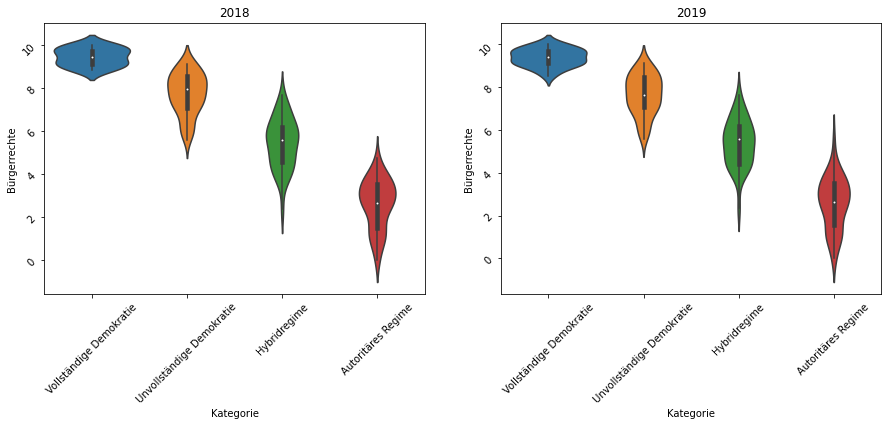

In [297]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
sns.violinplot(x = "Kategorie", y = "Bürgerrechte", data = df_INDEX2018, ax = ax[0])
sns.violinplot(x = "Kategorie", y = "Bürgerrechte", data = df_INDEX2019, ax = ax[1])
ax[0].title.set_text("2018")
ax[1].title.set_text("2019")
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
plt.show()

In [298]:
#Rename the columns of the EIU dataframe with more descriptive names
EIU_col = df_EIU.columns
#var that contains all numbers as string, needed to delete all numbers from strings
str_num = "0123456789"
#dict of more descriptive column names
dic_col = {"VA":"Demokratie",
           "PV":"Politische Stabilität",
           "GE":"Positive Bürokratie",
           "RQ":"Sozialer Markt",
           "RL":"Gesetz",
           "CC":"Korruptionsprävention"}

#Strip "EIU" from columns
EIU_cat1 = []
n = 0
for i in EIU_col:
    
    a = i[0]
    a = a.replace("EIU", "")
    
    #Strip year from columns
    if n > 1:
        a = a.strip(str_num)
    #renaming of the columns, try/except due to the columns that are not in the dict
    try:
        a = dic_col[a]
    except:
        pass
    EIU_cat1.append(a)    
    n += 1

#List of the years in the columns
EIU_cat2 = []
for i in EIU_col:
    EIU_cat2.append(i[1])

EIU_cat1[0] = "Land"

#Use new multicolumn
EIU_col_new = pd.MultiIndex.from_tuples(list(zip(EIU_cat1,EIU_cat2)))
df_EIU.columns = EIU_col_new
df_EIU.head(15)

,Land,Code,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,...,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention
,,Year,2019,2019,2019,2019,2019,2019,2018,2018,...,1998,1998,1998,1998,1996,1996,1996,1996,1996,1996
0,Aruba,ABW,0.81250,0.75,0.625,0.7,0.84375,0.75,0.81250,0.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,0.17375,0.1,0,0.2,0.09375,0,0.17975,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,0.34225,0.6,0.125,0.4,0.28125,0,0.33725,0.6,...,0.000,0.20,0.06250,0.00,0.0625,0.15,0.000,0.20,0.06250,0.00
3,Albania,ALB,0.57575,0.55,0.25,0.65,0.375,0.25,0.58025,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,ARE,0.23175,0.8,0.75,0.75,0.71875,0.75,0.23175,0.8,...,0.500,0.75,0.56250,0.25,0.2500,0.75,0.500,0.75,0.56250,0.25
5,Argentina,ARG,0.63225,0.55,0.375,0.45,0.4375,0.5,0.63225,0.6,...,0.500,0.65,0.50000,0.25,0.3750,0.55,0.625,0.65,0.50000,0.25
6,Armenia,ARM,0.49575,0.4,0.375,0.5,0.5,0.25,0.45825,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Australia,AUS,0.86075,0.85,1,0.9,0.9375,1,0.86075,0.85,...,0.625,0.75,0.93750,0.75,0.6875,0.95,0.625,0.70,0.93750,0.75
8,Austria,AUT,0.85200,0.85,0.75,0.8,0.96875,0.75,0.85200,0.85,...,1.000,0.75,0.93750,1.00,0.8125,0.95,1.000,0.75,0.93750,1.00


In [299]:
#renaming the columns
df_INDEX2019_ISO.columns = ['Land', 'Dem_Score_Total', 'Electoral_process_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Regime_type', 'Code2',
       'country_ger', 'country_en', 'Code3']

In [300]:
df_INDEX2019_ISO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Land                         139 non-null    object 
 1   Dem_Score_Total              139 non-null    float64
 2   Electoral_process_pluralism  139 non-null    float64
 3   Functioning_of_government    139 non-null    float64
 4   Political_participation      139 non-null    float64
 5   Political_culture            139 non-null    float64
 6   Civil_liberties              139 non-null    float64
 7   Regime_type                  139 non-null    object 
 8   Code2                        139 non-null    object 
 9   country_ger                  139 non-null    object 
 10  country_en                   139 non-null    object 
 11  Code3                        139 non-null    object 
dtypes: float64(6), object(6)
memory usage: 14.1+ KB


# Dataset 3: Population data

Datacleaning and processing (done external so data can be stored in GitHub): Sebastian, (Philipp)

In [301]:
population = "https://raw.githubusercontent.com/supermonti1999/TechLabs_Projekt/main/POP_ISO.csv"
df_population = pd.read_csv(population, index_col = "Unnamed: 0")
#Info: Population given in 1000

#What: Adding a mean age per age-group
#Why: In order to be able to calculate the mean age of a population
df_population["AgeGrpMid"] = df_population["AgeGrpStart"] + 2
#Dropping not needed columns
df_population.drop(axis = 1, columns = ["Variant", "Time", "MidPeriod", "AgeGrpSpan"], inplace = True)

#Changing the order of the columns for cosmetic reasons
df_population = df_population[['Location', 'Code_3_digits', 'AgeGrp', 'AgeGrpStart', 'AgeGrpMid', 
                              'PopMale', 'PopFemale', 'PopTotal']]

#What: Create Dataframe of the Population Density with three Digit Codes
#Source: Data extracted from  https://population.un.org/wpp/Download/Standard/CSV/ for the Total Population and the Population Density. 
df= pd.read_csv('WPP2019_TotalPopulationBySex.csv')

#What:Filtering of the data for the relevant data
#Why: In order to extract the relevant data
Filter_2020=df['Time']==2020 
Filter_2020_v1=(df['Variant']=='Medium') 


df_POP_Density=df[Filter_2020_v1& Filter_2020]

#What: Modyfing the dataframe by eliminating the superfluos columns

df_POP_Density.head()
df_ISO_en.head() 
#Info: Population density per square kilometer(thousands)
#What:Add three digit codes for the countrys to the dataframe
#Why: In order to merge it with the "Master" dataframe
df_POP_Density= pd.merge(df_POP_Density, df_ISO_en, left_on='Location',right_on='country_en')

#Drop the unnecessary columns of the data
df_POP_Density=df_POP_Density[['PopDensity','Code3']]
#What: Check for Nan Values?
#Why:. To secure that the data fits
#df_POP_Density["Code_3_digits"].isnull().sum()
df_POP_Density.columns=['PopDensity_per_sq','Code3']
df_POP_Density.head()

,PopDensity_per_sq,Code3
0,59.627,AFG
1,105.029,ALB
2,18.411,DZA
3,275.985,ASM
4,164.394,AND


In [302]:
#Adding a column for the percentage of an age group in a population
df_population["AgePercPop"] = np.nan

#What: Creating a list of all individual countrys
#Why: In order to calculate the mean age and the percentage of each agegroup for each country separately
list_pop_ISO = df_population.Code_3_digits.unique()

#Calculation of the percentage of each age group in the population of the individual countrys
for i in list_pop_ISO:
    #Calculate the total population of a country
    sum_PopTotal = df_population.loc[df_population.Code_3_digits == i].PopTotal.sum()
    #Calculate the percentages, #"\" in order to start new line
    df_population.loc[df_population.Code_3_digits == i, "AgePercPop"] = \
    df_population.loc[df_population.Code_3_digits == i, "PopTotal"] / sum_PopTotal

    
#Calcuation of the mean age of each country AND    
#Caculation of the total population per country


#Adding a column (removed later) that is the product of Age and Population 
#AND the mean age of a country
#AND the Total population per country

df_population["Age_X_Pop"] = df_population["AgeGrpMid"] * df_population["PopTotal"]
df_population["AgeCountryMean"] = np.nan
df_population["PopTotalCountry"] = np.nan

for i in list_pop_ISO:
    sum_PopTotal = df_population.loc[df_population.Code_3_digits == i].PopTotal.sum()
    df_population.loc[df_population.Code_3_digits == i, "PopTotalCountry"] = sum_PopTotal    
    mean_age = df_population.loc[df_population.Code_3_digits == i, "Age_X_Pop"].sum()/sum_PopTotal
    df_population.loc[df_population.Code_3_digits == i, "AgeCountryMean"] = mean_age

#Dropping the not no longer needed column
df_population.drop(axis = 1, columns = ["Age_X_Pop"], inplace = True)

#Changing the order of the columns for cosmetic reasons
df_population = df_population[['Location', 'Code_3_digits', 'AgeGrp', 'AgeGrpStart', 'AgeGrpMid', 
                               'AgePercPop', 'AgeCountryMean','PopMale', 'PopFemale', 'PopTotal',
                               'PopTotalCountry']]

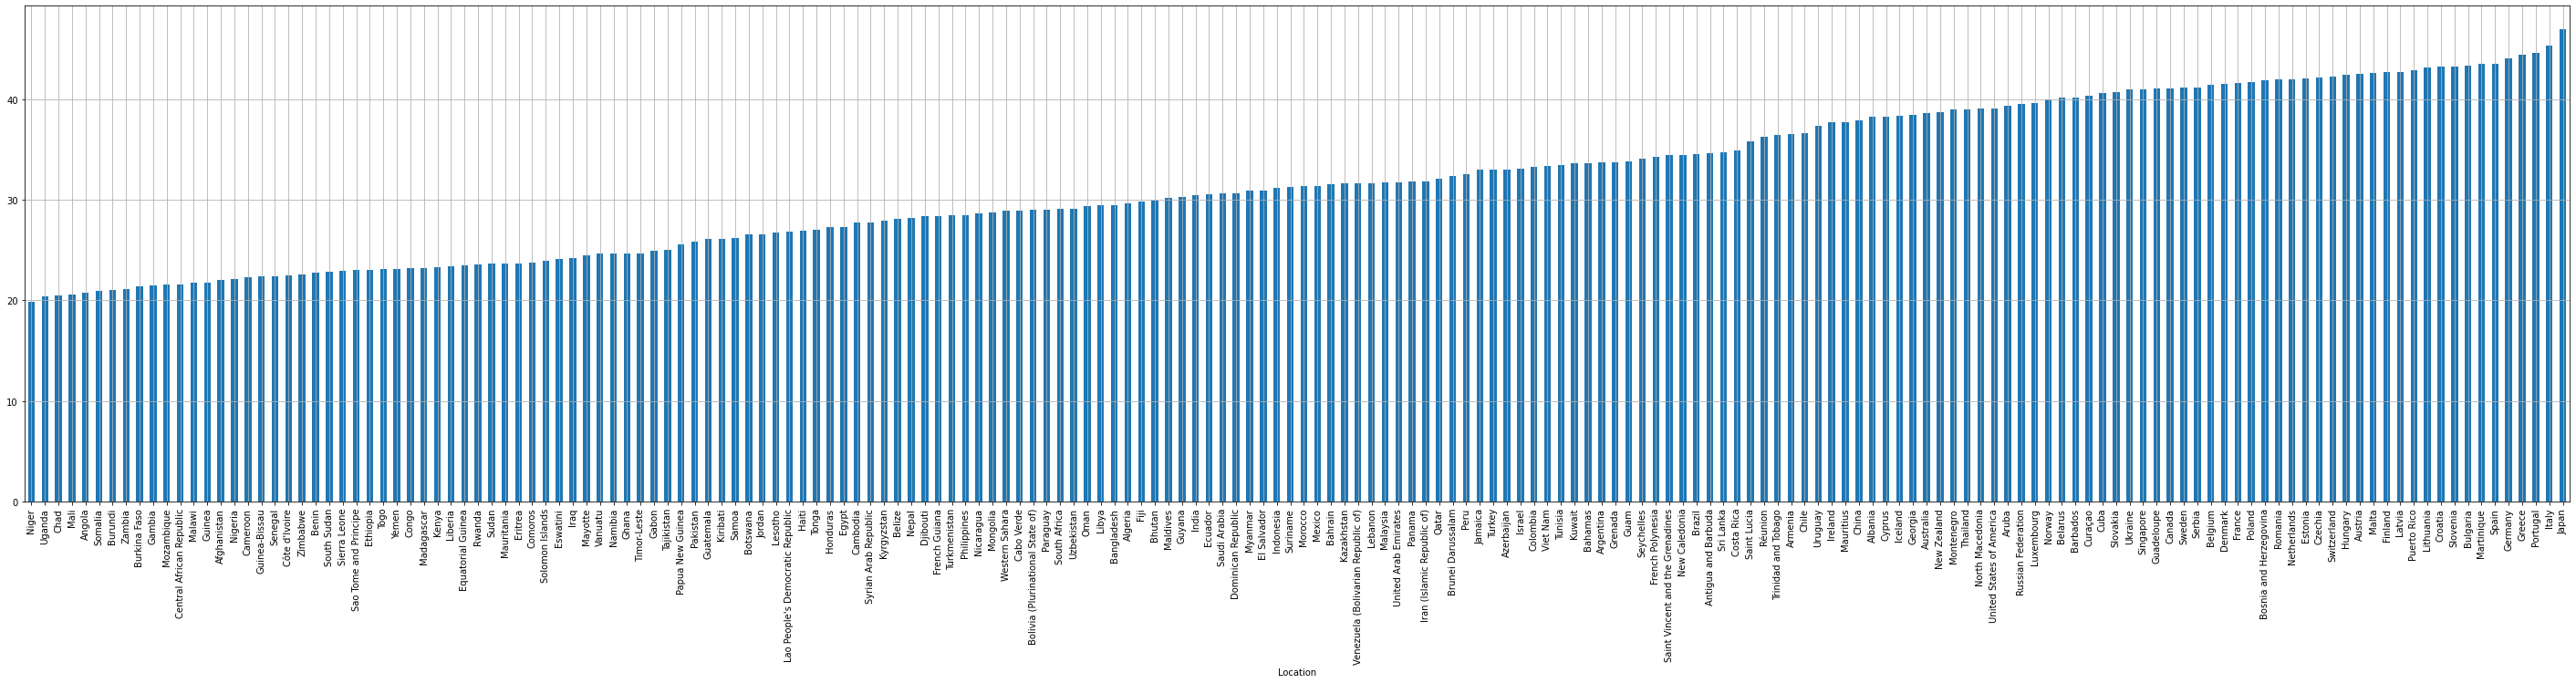

In [303]:
#Visualisation of the mean age per country in a bar plot (click to zoom)
plt.figure(figsize = (50,10))
df_population.groupby("Location").mean().AgeCountryMean.sort_values().plot.bar()
plt.grid(which="Major")
plt.show()

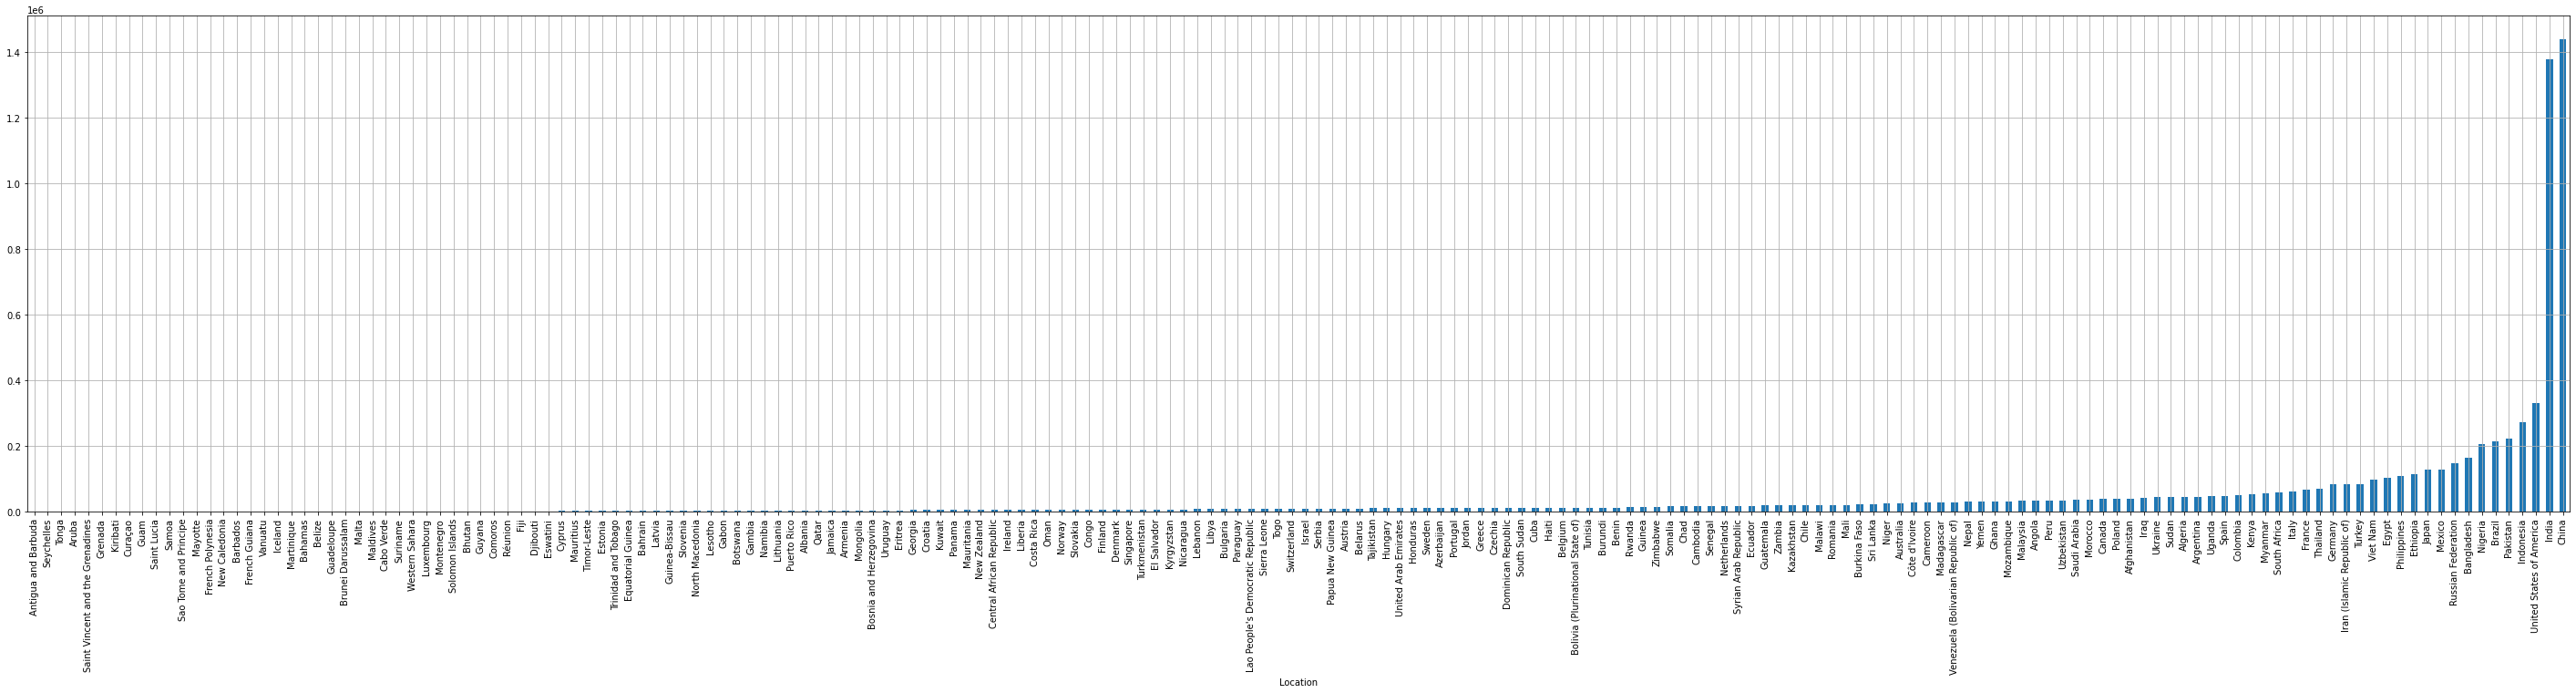

In [304]:
#Visualisation of the total population per country in a bar plot (click to zoom)
plt.figure(figsize = (50,10))
df_population.groupby("Location").mean().PopTotalCountry.sort_values().plot.bar()
plt.grid(which="Major")
plt.show()

# Merging of the collected data

Putting together all the data: Philipp

In [305]:
#Grouping of the population data by country and dropping columns
df_population_aggr = df_population.groupby("Code_3_digits").mean()[["AgeCountryMean", "PopTotalCountry"]]
#Merging of the demcracy data and the population data
df_INDEX_POP = pd.merge(df_INDEX2019_ISO, df_population_aggr, how = "outer", left_on = "Code3", 
                        right_index= True)
df_INDEX_POP.reset_index(inplace=True, drop = True)


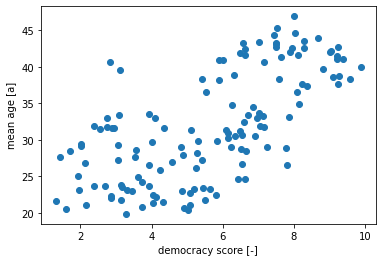

In [306]:
#Testplot, mean age versus democracy score
x = df_INDEX_POP["Dem_Score_Total"]
y = df_INDEX_POP["AgeCountryMean"]
plt.scatter(x,y)
plt.ylabel("mean age [a]")
plt.xlabel("democracy score [-]")
plt.show()

In [307]:
#Oxfort Dataframe, Index reset
ox.reset_index(inplace=True, drop = True)


### "Master"-Dataframe

In [308]:
#Merging into the "Master"-Dataframe
df_corona = pd.merge(ox, df_INDEX_POP, left_on = "CountryCode", right_on= "Code3", how = "outer")

In [309]:
#Dropping few columns
df_corona.drop(axis = 1, columns = ["Code2", "country_ger", "Land"], inplace = True)

In [310]:
df_corona.loc[df_corona.CountryCode == "DEU"].head()

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,...,Electoral_process_pluralism,Functioning_of_government,Political_participation,Political_culture,Civil_liberties,Regime_type,country_en,Code3,AgeCountryMean,PopTotalCountry
11172,Germany,DEU,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783.945
11173,Germany,DEU,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783.945
11174,Germany,DEU,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783.945
11175,Germany,DEU,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783.945
11176,Germany,DEU,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783.945


In [312]:
#Merging dataframe of Population Density 
df_corona= pd.merge(df_corona, df_POP_Density,left_on='CountryCode', right_on='Code3',how='outer')
#df_corona.drop(axis=1, columns=['Code3_y','PopDensity_per_sq_y','PopDensity_per_sq_x'], inplace=True)
df_corona.loc[df_corona.CountryCode == 'AFG'].head()

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,...,Political_participation,Political_culture,Civil_liberties,Regime_type,country_en,Code3_x,AgeCountryMean,PopTotalCountry,PopDensity_per_sq,Code3_y
266,Afghanistan,AFG,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,3.89,2.5,3.82,Autoritäres Regime,Afghanistan,AFG,22.061093,38928.341,59.627,AFG
267,Afghanistan,AFG,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,3.89,2.5,3.82,Autoritäres Regime,Afghanistan,AFG,22.061093,38928.341,59.627,AFG
268,Afghanistan,AFG,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,3.89,2.5,3.82,Autoritäres Regime,Afghanistan,AFG,22.061093,38928.341,59.627,AFG
269,Afghanistan,AFG,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,3.89,2.5,3.82,Autoritäres Regime,Afghanistan,AFG,22.061093,38928.341,59.627,AFG
270,Afghanistan,AFG,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,3.89,2.5,3.82,Autoritäres Regime,Afghanistan,AFG,22.061093,38928.341,59.627,AFG


In [317]:
#What:Adding new columns that puts death into perspective
#Why: In order to secure comparability for the data
df_corona['ConCases_Pop']=df_corona['ConfirmedCases']/df_corona['PopTotalCountry']
df_corona['ConDeaths_Pop']=df_corona['ConfirmedDeaths']/df_corona['PopTotalCountry']
df_corona['ConCases_perDay_Pop']=df_corona['ConfirmedCases_per_day']/df_corona['PopTotalCountry']
df_corona['ConDeaths_perDay_Pop']=df_corona['ConfirmedDeaths_per_day']/df_corona['PopTotalCountry']

In [318]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47161 entries, 0 to 47160
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   CountryName                            47082 non-null  object        
 1   CountryCode                            47082 non-null  object        
 2   Date                                   47082 non-null  datetime64[ns]
 3   C1_School closing                      47082 non-null  float64       
 4   C1_Flag                                29917 non-null  float64       
 5   C2_Workplace closing                   47082 non-null  float64       
 6   C2_Flag                                28001 non-null  float64       
 7   C3_Cancel public events                47082 non-null  float64       
 8   C3_Flag                                31156 non-null  float64       
 9   C4_Restrictions on gatherings          47082 non-null  float6

In [ ]:
#